<a href="https://colab.research.google.com/github/YusufBerkayAcar/Plastic-Type-Recognation-Transformer-Model/blob/main/PlasticTypeRecognationTransformerModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Drive dosya okuma
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
#Çözürnürlüğü düşük ve bozuk görsellerin çıkartılması , yeniden boyutlandırılması.
import os
from PIL import Image
import shutil

def resize_images(input_dir, output_dir, size=(224, 224)):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)  # önceki içerikleri sil (isteğe bağlı)
    os.makedirs(output_dir, exist_ok=True)

    for class_folder in os.listdir(input_dir):
        class_input_path = os.path.join(input_dir, class_folder)
        class_output_path = os.path.join(output_dir, class_folder)
        os.makedirs(class_output_path, exist_ok=True)

        for img_file in os.listdir(class_input_path):
            input_img_path = os.path.join(class_input_path, img_file)
            output_img_path = os.path.join(class_output_path, img_file)
            try:
                img = Image.open(input_img_path).convert("RGB")
                img = img.resize(size)
                img.save(output_img_path)
            except Exception as e:
                print(f"Hata: {input_img_path} -> {e}")

# Kullanım:
resize_images(
    input_dir="/content/drive/MyDrive/PlasticTypes",
    output_dir="/content/drive/MyDrive/resized_plastic_types"
)


In [ ]:
#Veri setinin train , val , test olarak bölünmesi (%80,%10,%10)
import os
import shutil
import random
from pathlib import Path


In [ ]:
# Orijinal veri klasörü (Drive'daki yolunu güncelle!)
dataset_dir = "/content/drive/MyDrive/resized_plastic_types"

# Yeni oluşturulacak train/val/test klasörlerinin konumu
output_base = "/content/drive/MyDrive/plastic_split"

# Oranlar
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Sınıf klasörlerini oku
classes = os.listdir(dataset_dir)

for class_name in classes:
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Dosyaları karıştır
    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_count = int(total * train_ratio)
    val_count = int(total * val_ratio)
    test_count = total - train_count - val_count  # Kalanlar test'e

    splits = {
        "train": images[:train_count],
        "val": images[train_count:train_count + val_count],
        "test": images[train_count + val_count:]
    }

    for split_name, split_images in splits.items():
        split_dir = os.path.join(output_base, split_name, class_name)
        Path(split_dir).mkdir(parents=True, exist_ok=True)

        for img_name in split_images:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(split_dir, img_name)
            shutil.copyfile(src, dst)

print("✅ Veri başarıyla train/val/test olarak bölündü.")


✅ Veri başarıyla train/val/test olarak bölündü.


In [ ]:
!pip install -q transformers datasets tensorflow pillow


In [ ]:
from transformers import ViTFeatureExtractor, TFAutoModelForImageClassification
import tensorflow as tf
import numpy as np
import os
from PIL import Image


In [ ]:
num_classes = 6  # PP, PE, PET, PC, PS, Others

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model = TFAutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=6,
    ignore_mismatched_sizes=True
)



In [ ]:
def get_image_paths_and_labels(data_dir):
    classes = sorted(os.listdir(data_dir))
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

    image_paths = []
    labels = []

    for cls_name in classes:
        cls_folder = os.path.join(data_dir, cls_name)
        for fname in os.listdir(cls_folder):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(cls_folder, fname))
                labels.append(class_to_idx[cls_name])

    return image_paths, labels, class_to_idx


train_dir = "/content/drive/MyDrive/plastic_split/train"
val_dir = "/content/drive/MyDrive/plastic_split/val"
test_dir = "/content/drive/MyDrive/plastic_split/test"

train_paths, train_labels, class_to_idx = get_image_paths_and_labels(train_dir)
val_paths, val_labels, _ = get_image_paths_and_labels(val_dir)
test_paths, test_labels, _ = get_image_paths_and_labels(test_dir)


In [ ]:
def preprocess_image(path, label):
    path = path.numpy().decode('utf-8')  # Tensor -> str dönüştür
    image = Image.open(path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="np")
    pixel_values = inputs['pixel_values'][0]
    return pixel_values, label


In [ ]:
def create_tf_dataset(image_paths, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def _load_image(path, label):
        pixel_values, label = tf.py_function(func=preprocess_image, inp=[path, label], Tout=[tf.float32, tf.int32])
        pixel_values.set_shape((3, 224, 224))  # TF modelleri genelde bu shape'i bekler
        label.set_shape(())
        return pixel_values, label

    dataset = dataset.map(_load_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


In [ ]:
batch_size = 32

train_ds = create_tf_dataset(train_paths, train_labels, batch_size=batch_size)
val_ds = create_tf_dataset(val_paths, val_labels, batch_size=batch_size, shuffle=False)
test_ds = create_tf_dataset(test_paths, test_labels, batch_size=batch_size, shuffle=False)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)  # veya 1e-4, 3e-5
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)


Epoch 1/10
79/79 [==============================] - 158s 1s/step - loss: 1.6204 - accuracy: 0.3659 - val_loss: 1.5988 - val_accuracy: 0.3599
Epoch 2/10
79/79 [==============================] - 114s 1s/step - loss: 1.2022 - accuracy: 0.5621 - val_loss: 1.4053 - val_accuracy: 0.4522
Epoch 3/10
79/79 [==============================] - 114s 1s/step - loss: 0.9169 - accuracy: 0.6713 - val_loss: 1.3208 - val_accuracy: 0.4873
Epoch 4/10
79/79 [==============================] - 114s 1s/step - loss: 0.7634 - accuracy: 0.7243 - val_loss: 1.3932 - val_accuracy: 0.5032
Epoch 5/10
79/79 [==============================] - 115s 1s/step - loss: 0.6689 - accuracy: 0.7433 - val_loss: 1.3314 - val_accuracy: 0.5127
Epoch 6/10
79/79 [==============================] - 115s 1s/step - loss: 0.5958 - accuracy: 0.7678 - val_loss: 1.3521 - val_accuracy: 0.5287
Epoch 7/10
79/79 [==============================] - 114s 1s/step - loss: 0.5092 - accuracy: 0.8006 - val_loss: 1.4067 - val_accuracy: 0.5255
Epoch 8/10
79

In [ ]:
model.save("model2.keras")

In [ ]:
# Test dataset hazır
test_ds = create_tf_dataset(test_paths, test_labels, batch_size=batch_size, shuffle=False)

# Test verisi üzerinde modelin performansını ölç
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


11/11 [==============================] - 5s 419ms/step - loss: 1.4797 - accuracy: 0.5590
Test Loss: 1.4797, Test Accuracy: 0.5590


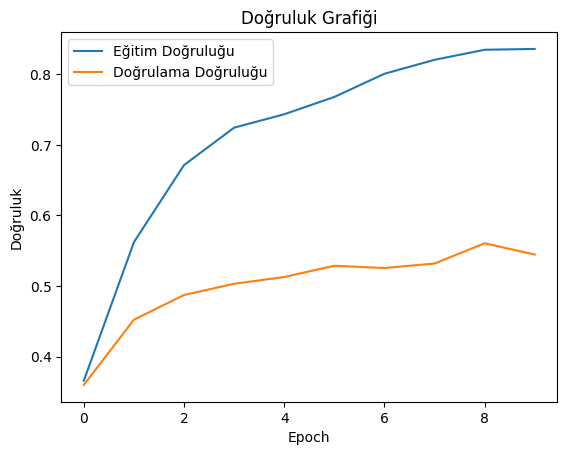

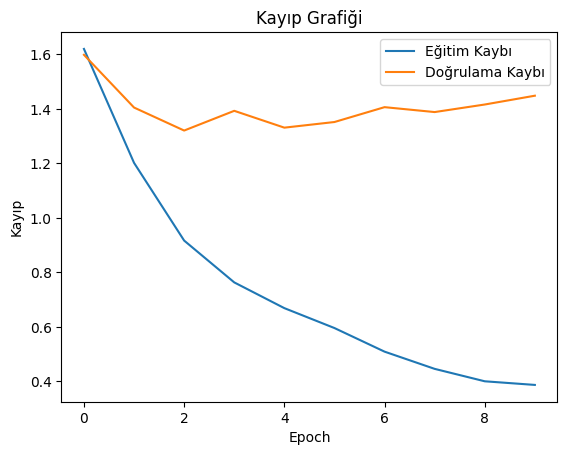

In [ ]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğruluğu
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

# Eğitim ve doğrulama kaybı
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Kayıp Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()
